## Построение рекомендаций с использованием "чистого" Python

In [1]:
import numpy as np
import pandas as pd
from scipy import spatial

import warnings
warnings.filterwarnings('ignore')


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import seaborn as  sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)

### Что есть "схожесть"

Как мы находим похожих пользователей основываясь на их рейтинге?

Рассмотрим на базовом примере:

1. У нас есть 4 пользователя A, B, C и D, которые оценили 2 рейтинга

2. Их оценки выглядят так:
    * A = [5.0, 1.0]
    * B = [4.0, 4.0]
    * C = [3.5, 2.5]
    * D = [2.0, 3.0]
    
3. Они располагаются в пространстве, где ось Y - это фильм 1, а X - это фильм 2

In [3]:
# переведем это в код
a = [5., 1.]
b = [4., 4.]
c = [3.5, 2.5]
d = [2., 3.]

labels = ["A", "B", "C", "D"]
data = np.append([a], [b], axis=0)
data = np.append(data, [c], axis=0)
data = np.append(data, [d], axis=0)

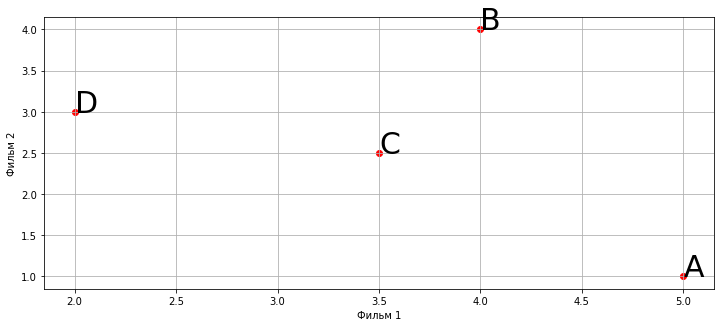

In [4]:
# визуализируем данные
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)

ax.scatter(data[:, 0], data[:, 1], color="red")

ax.set_xlabel("Фильм 1")
ax.set_ylabel("Фильм 2")


for i, word in enumerate(data):
    ax.annotate(labels[i], xy=(data[i, 0], data[i, 1]), size=30)
plt.grid(True)
plt.show()

Каждая точка == пользователь. 

Дистанция между двумя точками - это лучший вариант посчитать похожесть пользователей. На графике уже видно, что есть 2 похожих.

Найдем расстояние между точкам:

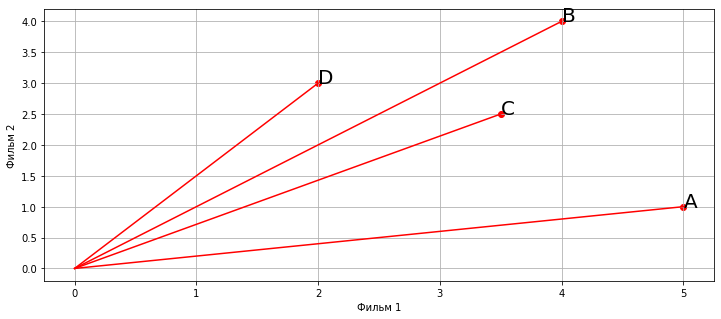

In [5]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)

ax.scatter(data[:, 0], data[:, 1], color="red")

ax.set_xlabel("Фильм 1")
ax.set_ylabel("Фильм 2")

for i, word in enumerate(data):
    ax.plot(np.array([0,data[i][0]]), np.array([0, data[i][1]]), color="red")
    ax.annotate(labels[i], xy=(data[i, 0]+0.001, data[i, 1]), size=20)
plt.grid(True)
plt.show()

### разные варианты сходства

In [6]:
def euclidean_distance(x,y):
    from math import pow, sqrt
    return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

In [7]:
def manhattan_distance(x,y):
    return sum(abs(a-b) for a,b in zip(x,y))

In [8]:
def nth_root(value, n_root):
    from decimal import Decimal
    root_value = 1/float(n_root)
    return round (Decimal(value) ** Decimal(root_value),3)
  
def minkowski_distance(x,y,p_value):
    from math import pow
    return nth_root(sum(pow(abs(a-b),p_value) for a,b in zip(x, y)),p_value)

In [9]:
def square_rooted(x):
    from math import pow, sqrt
    return round(sqrt(sum([a*a for a in x])),3)
  
def cosine_similarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return round(numerator/float(denominator),3)

In [10]:
euclidean_distance(a,c)

2.1213203435596424

In [11]:
manhattan_distance(a,c)

3.0

In [12]:
# p = 2 - это считается, как Эвклидово
# p = 1 - это считается, как Манхэттен 
minkowski_distance(a,c, 1), minkowski_distance(a,c, 2)

(Decimal('3.000'), Decimal('2.121'))

In [17]:
minkowski_distance(a,c, 10)

Decimal('1.608')

In [14]:
cosine_similarity(a,c)

0.912

### из библиотеки

In [18]:
# расстояние одной точки А до остальных
print("A-C:",spatial.distance.euclidean(a, c))
print("A-B:", spatial.distance.euclidean(a, b))
print("A-D:", spatial.distance.euclidean(a, d))

# действительно считает)
print("A-А:", spatial.distance.euclidean(a, a))

A-C: 2.1213203435596424
A-B: 3.1622776601683795
A-D: 3.605551275463989
A-А: 0.0


In [19]:
print("C-A:", spatial.distance.cosine(c,a))
print("C-B:", spatial.distance.cosine(c,b))
print("C-D:", spatial.distance.cosine(c,d))

C-A: 0.0880784948248936
C-B: 0.013606076167856251
C-D: 0.06500247368221657


In [20]:
# сделаем расчет по всем точкам

dot_list = [a, b, c, d]

df = pd.DataFrame(columns = ['U1', 'U2', 'SIM'])

n=0

for i in dot_list:
    for j in dot_list:
        
        if i != j :
            
            # используйте выбранный метод и заполните таблицу 
            result = spatial.distance.cosine(i,j)
            df.loc[n] = [i, j, result]
            
            n+=1
        
df.sort_values(by = 'SIM')

,U1,U2,SIM
4,"[4.0, 4.0]","[3.5, 2.5]",0.013606
7,"[3.5, 2.5]","[4.0, 4.0]",0.013606
5,"[4.0, 4.0]","[2.0, 3.0]",0.019419
10,"[2.0, 3.0]","[4.0, 4.0]",0.019419
8,"[3.5, 2.5]","[2.0, 3.0]",0.065002
11,"[2.0, 3.0]","[3.5, 2.5]",0.065002
1,"[5.0, 1.0]","[3.5, 2.5]",0.088078
6,"[3.5, 2.5]","[5.0, 1.0]",0.088078
0,"[5.0, 1.0]","[4.0, 4.0]",0.167950
3,"[4.0, 4.0]","[5.0, 1.0]",0.167950


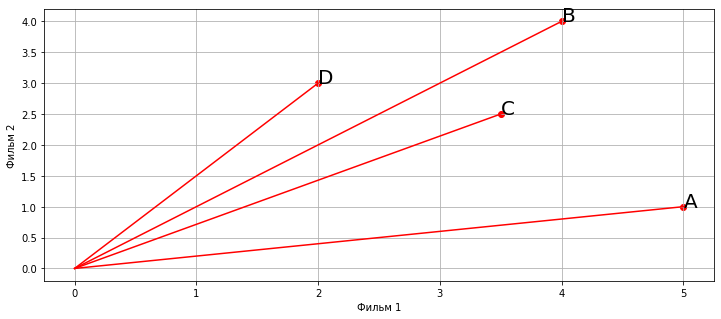

In [21]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)

ax.scatter(data[:, 0], data[:, 1], color="red")

ax.set_xlabel("Фильм 1")
ax.set_ylabel("Фильм 2")

for i, word in enumerate(data):
    ax.plot(np.array([0,data[i][0]]), np.array([0, data[i][1]]), color="red")
    ax.annotate(labels[i], xy=(data[i, 0]+0.001, data[i, 1]), size=20)
plt.grid(True)
plt.show()

Самые далекие точки C - A, а близкие B - D

С - пользователь имеет очень похие оценки, возможно, он занижает все оценки по личным причинам.

А - пользователь, это самый интересный случай, когда оценивают, только минимально - максимально.


### Коллаборативная фильтрация (KNN)

In [22]:
import pandas as pd
import numpy as np
import random
import sklearn
import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics
import sklearn.metrics.pairwise
import math


In [23]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')

#сделаем разбивку
train_ratings, test_ratings = sklearn.model_selection.train_test_split(ratings, test_size=0.2)

### K-Nearest Neighbors
--------------------

Для поиска похожих предметов/пользователей мы должны использовать любую метрику схожести. Метрика определяется, как расстояние между двумя векторами.

$$\cos(A,B)=\frac{\sum\limits_{i}^{N}A_iB_i}{\sqrt{\sum\limits_{i}^{N}A_i^2} \sqrt{\sum\limits_{i}^{N}B_i^2}} $$

In [24]:
train_ratings.head(5)

,userId,movieId,rating,timestamp
44110,311,4795,3.0,1091465146
87032,580,3948,2.5,1269895083
42621,306,1096,4.0,939814997
55608,402,6934,2.5,1443394446
32535,235,1513,3.5,1111558190


In [25]:
#сделаем наборы для более удобного поиска
movie_users = {}
user_movies = {}
for index, row in train_ratings.iterrows():
    if row['movieId'] not in movie_users:
        movie_users[row['movieId']] = {}
        
    if row['userId'] not in user_movies:
        user_movies[row['userId']] = {}
        
    movie_users[row['movieId']][row['userId']] = row['rating']
    user_movies[row['userId']][row['movieId']] = row['rating']


In [26]:
# сделаем расчет по всем пользователям
# проверяем разницу на основе cos(A,B)
similarities = {}

# все фильмы пользователя 1
for user1 in user_movies:
    if user1 not in similarities:
        similarities[user1] = {}
    
    # все фильмы пользователя 2
    for user2 in user_movies:
        if user2 in similarities[user1] or user1 == user2:
            continue
        
        user1_ratings = []
        user2_ratings = []
        
        # только те фильме, которые оба пользователя смотрели
        for key in user_movies[user1]:
            watched_users = movie_users[key]
            if user1 in watched_users and user2 in watched_users:
                user1_ratings.append(watched_users[user1])
                user2_ratings.append(watched_users[user2])
                
        if len(user1_ratings) > 0:
            if user2 not in similarities:
                similarities[user2] = {}
            
            # делаем расчет расстояния
            sim = np.dot(user1_ratings, user2_ratings) / (np.linalg.norm(user1_ratings) * np.linalg.norm(user2_ratings))
            similarities[user1][user2] = sim
            similarities[user2][user1] = sim

Используя похожесть пользователей, сделаем поиск ближайших соседей по формуле

$$R_{x,y} = \frac{\sum\limits_{z} Sim_{x,z}R_{z,y}}{\sum\limits_{z} Sim_{x,z}}$$


In [27]:
#KNN
def knn_predict(k, userId, movieId):
    watched_users = movie_users[movieId]
    
    sim_scores = []
    rating_scores = []
    
    for w in watched_users:
        if w in similarities[userId]:
            sim_scores.append(similarities[userId][w])
            rating_scores.append(watched_users[w])
    
    #Считаем скоринг и находим ближайших
    if len(sim_scores) > 0:
        sim_df = pd.DataFrame(data={'sim' : sim_scores, 'rating' : rating_scores})
        
        # делаем сортировку
        sorted_sim_df = sim_df.sort_values(by=['sim'], ascending = False)
        # отбор топ - это и есть ближайшие
        knearest = sorted_sim_df.head(k)
        
        numerator = 0
        denomenator = 0
        for index, row in knearest.iterrows():
            numerator += row['sim'] * row['rating']
            denomenator += row['sim']
        return numerator / denomenator
    else: 
        # можно возвращать любой случайный рейтинг или средний по всем
        return 2.5
    

In [28]:
# сделаем расчет

# определим кол-во ближайших соседей (набор, чтобы увидеть разницу) 
Ks= [10, 15, 20, 25]

# сделаем подбор для тех, кто есть в тестовой выборке
for K in Ks:
    predicted_ratings = []
    actual_ratings = []

    for index, row in test_ratings.iterrows():
        if row['movieId'] not in movie_users:
            continue

        pred = knn_predict(K, row['userId'], row['movieId'])

        # сохраним результат
        predicted_ratings.append(pred)
        actual_ratings.append(row['rating'])
    
    # метрика (факт / предикт)
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(predicted_ratings, actual_ratings))
    print("K - ", K, " | RMSE:", rmse)

K -  10  | RMSE: 1.00539696861085
K -  15  | RMSE: 0.9972264610010386


KeyboardInterrupt: 

#### KNN - но библиотекой Surprise

Способ из библиотек, конечно, лучше.

Мы можем использовать:
- разные метрики для поиска похожих элементов: cosine, msd, pearson, pearson_baseline
- использовать user_base / item_based подходы 
- min_support - минимальное кол-во предметов в наборе для поиска


In [30]:
from surprise import Dataset
from surprise import Reader

from surprise.model_selection import train_test_split

from surprise import KNNWithMeans, accuracy

In [31]:
# подготовим заново данные
df = pd.read_csv("ratings.csv")
movie_titles = pd.read_csv('movies_titles.csv') 
df['item_id'] = df['movieId']
df = df.drop('movieId', axis = 1)

movielens = pd.merge(df, movie_titles, on='item_id') 

movielens.head(5)

,userId,rating,timestamp,item_id,title
0,1,2.5,1260759144,31,Crimson Tide (1995)
1,7,3.0,851868750,31,Crimson Tide (1995)
2,31,4.0,1273541953,31,Crimson Tide (1995)
3,32,4.0,834828440,31,Crimson Tide (1995)
4,36,3.0,847057202,31,Crimson Tide (1995)


In [33]:
# для работы с библиотекой surprise необходимо подготовить данные

# создать объект с мин/макс. оценков
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(movielens[['userId', 'item_id', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=28)

In [34]:
# используем такую же item-based рекомендацию на основе схожести по косиносному расстоянию
sim_options = {
    "name": "cosine",
    "user_based": False,  # расстояние между предметами, не пользователями
}
algo = KNNWithMeans(sim_options=sim_options)

In [35]:
# обучение
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [41]:
# приедикт для одного пользователя
prediction = algo.predict(2718281828, 2)
prediction

Prediction(uid=2718281828, iid=2, r_ui=None, est=3.644603458556947, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

! Ого !

Наш результат 3.64 для фильма 2, но что значит эта надпись: **"'reason': 'User and/or item is unknown"**

In [44]:
# правильный предитк (известный пользователь, не известный предмет для пользователя)
algo.predict(1, 2)

Prediction(uid=1, iid=2, r_ui=None, est=2.1845941951760435, details={'actual_k': 8, 'was_impossible': False})

In [45]:
accuracy.rmse(algo.test(testset))

RMSE: 0.8959


0.8958626002260517

<hr>

Matrix Factorization (Рассмотрим на занятии 2)
--------

Более мощное решение задачи. Коллаборативная фильтрация методом матричного разложения. Применяется для user-item рекомендаций.

<table>
    <tr>
        <th></th>
        <th>Movie1</th>
        <th>Movie2</th>
        <th>Movie3</th>
        <th>Movie4</th>
    </tr>
    <tr>
        <th>User1</th>
        <td>5</td>
        <td></td>
        <td>1.5</td>
        <td>3.5</td>
    </tr>
    <tr>
        <th>User2</th>
        <td>1</td>
        <td>3.5</td>
        <td></td>
        <td>4</td>
    </tr>
    <tr>
        <th>User3</th>
        <td></td>
        <td>2</td>
        <td>4</td>
        <td>5</td>
    </tr>
</table>

Есть много методов, основной метод [Probabilistic Matrix Factorization](https://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf):
$$ R = U^TV$$

### $U$ и $V$ ######

Как обучать U и V? Методом градиентного спуска и ALS, минимизируя функцию:

$$ 
E = \frac{1}{2} \sum\limits_{i}^{N}\sum\limits_{j}^{M}I_{i,j}(R_{i,j} - U_{i}^{T}V_{j})^2 
+ \frac{\lambda_U}{2} \sum\limits_{i}^{N} \|{U_i}\|_{Fro}^2
+ \frac{\lambda_V}{2} \sum\limits_{j}^{M} \|{V_j}\|_{Fro}^2
$$

In [ ]:
# функция ошибки
def get_error(user_matrix, item_matrix, actual, lu, li):
    error = 0
    for u in actual:
        for i in actual[u]:
            pred = np.dot(user_matrix[u], item_matrix[i])
            error += (pred - actual[u][i]) ** 2
            
    error /= 2
    
    u_norm = 0
    for u in user_matrix:
        for val in user_matrix[u]:
            u_norm += val ** 2
    i_norm = 0
    for i in item_matrix:
        for val in item_matrix[i]:
            i_norm += val ** 2
            
    error += lu * u_norm / 2
    error += li * i_norm / 2
              
    return error
    
    
#производная U
def dE_u(user_matrix, item_matrix, actual, lu, u, index):
    derivative = 0
    for i in actual[u]:
        pred = np.dot(user_matrix[u], item_matrix[i])
        derivative += (pred - actual[u][i]) * item_matrix[i][index]
        
    derivative += lu * user_matrix[u][index]
    
    return derivative 

#производная V
def dE_i(user_matrix, item_matrix, actual, li, i, index):
    derivative = 0
    watched_users = movie_users[i]
    for u in watched_users:
        pred = np.dot(user_matrix[u], item_matrix[i])
        derivative += (pred - actual[u][i]) * user_matrix[u][index]
        
    derivative += li * item_matrix[i][index]
    
    return derivative




#ALS
def learn(user_matrix, item_matrix, actual, lu, li, learning_rate):
    counter = 0
    while counter < 10:
        error = get_error(user_matrix, item_matrix, actual, lu, li)
        print("Counter:", counter, "Error:", error) #Error should trend downwards over time
        
        #Используем V константой, обновляем U с градиентом
        if counter % 2 == 0:
            user_derivatives = {}      
            for u in user_matrix:
                user_derivatives[u] = []
            
                for index in range(len(user_matrix[u])):
                    user_derivatives[u].append(dE_u(user_matrix, item_matrix, actual, lu, u, index))
                    
            for u in user_matrix:
                for index in range(len(user_matrix[u])):
                    user_matrix[u][index] -= learning_rate * user_derivatives[u][index]

        #Используем U константой, обновляем V с градиентом
        else:
            item_derivatives = {}
            for i in item_matrix:
                item_derivatives[i] = []
                for index in range(len(item_matrix[i])):
                    item_derivatives[i].append(dE_i(user_matrix, item_matrix, actual, li, i, index))
                    
            for i in item_matrix:
                for index in range(len(item_matrix[i])):
                    item_matrix[i][index] -= learning_rate * item_derivatives[i][index]
        
        counter += 1
        
    return (user_matrix, item_matrix)

In [ ]:
user_matrix = {}
item_matrix = {}
learning_rate = 0.0001
lu = 0.0001
li = 0.0001
K = 5

for u in user_movies:
    user_matrix[u] = random.sample(range(1, 100), K)
    for index in range(K):
        user_matrix[u][index] /= float(100)
    
for i in movie_users:
    item_matrix[i] = random.sample(range(1, 100), K)
    for index in range(K):
        item_matrix[i][index] /= float(100)
    
learned_users, learned_items = learn(user_matrix, item_matrix, user_movies, lu, li, learning_rate)

In [ ]:
predicted_ratings = []
actuals = []
not_count = 0
for index, row in test_ratings.iterrows():
    if row['movieId'] not in movie_users:
        continue
        
    pred = np.dot(learned_users[row['userId']], learned_items[row['movieId']])
    predicted_ratings.append(pred)
    actuals.append(row['rating'])

rmse = math.sqrt(sklearn.metrics.mean_squared_error(predicted_ratings, actuals))
print("RMSE:", rmse)

## MF - но библиотекой Surprise

In [ ]:
from surprise import SVD, accuracy

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(movielens[['userId', 'item_id', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.25)

Используем алгоритм SVD, т.к. он один из самых популярных, его автор Simon Funk.

In [ ]:
algo = SVD()
algo.fit(trainset)

predictions = algo.test(testset)

In [ ]:
accuracy.rmse(predictions)